In [132]:
# from softcomputing_packages_bu import *
from apyori import apriori
import pandas as pd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt

In [133]:
# Load dataset
hc_csv_raw = pd.read_csv('datasets/2.0-discretized-v2-2-with-label-resampled.csv').drop(columns=['i'])
hc_csv_raw.head()
len(hc_csv_raw)

41673

In [134]:
# Sampling (for Development)
n_sample = 30000
hc_csv = hc_csv_raw.sample(frac=1, random_state=42)
hc_csv = hc_csv.iloc[:n_sample]
hc_csv.head()

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry,climate_control,other,weekend,month_name,season_name,day_name,peak_label_pred
35103,Medium,Very High,Very High,Medium,Medium,Low,High,High,True,april,spring,sunday,lower_than_usual
8049,Low,High,Very High,Low,Low,Low,Low,Medium,False,march,spring,tuesday,no_significant_change
22355,Low,Medium,Medium,Low,Medium,High,Medium,Low,False,september,autumn,friday,peak_warning
21779,Medium,Very High,Medium,Medium,Very High,Very High,High,Medium,True,june,summer,saturday,peak_warning
40302,Low,Medium,High,Low,High,High,Medium,Medium,False,march,spring,wednesday,lower_than_usual


In [135]:
# Preprocess dataset
for c in range(8):
    print(c)
    print("[%d] Column Preprocessing: %s" %(c, hc_csv.columns[c]))
    for r in range(hc_csv.shape[0]):
        if(hc_csv.iloc[r,c]=='Very High'):
            hc_csv.iloc[r,c] = hc_csv.columns[c]+' 75-100%'
        elif(hc_csv.iloc[r,c]=='High'):
            hc_csv.iloc[r,c] = hc_csv.columns[c]+' 50-75%'
        elif(hc_csv.iloc[r,c]=='Medium'):
            hc_csv.iloc[r,c] = hc_csv.columns[c]+' 25-50%'
        elif(hc_csv.iloc[r,c]=='Low'):
            # hc_csv.iloc[r,c] = '-1'
            hc_csv.iloc[r,c] = hc_csv.columns[c]+' 0-25%'
        else:
            hc_csv.iloc[r,c] = '-1'
# for c in range(3):
#     print("[%d] Column Preprocessing: %s" %(c+7, hc_csv.columns[c+7]))
#     for r in range(hc_csv.shape[0]):
#         hc_csv.iloc[r,c+7] = hc_csv.columns[c+7]+' '+str(hc_csv.iloc[r,c+7])
print("Done.")

0
[0] Column Preprocessing: global_active_power
1
[1] Column Preprocessing: global_reactive_power
2
[2] Column Preprocessing: voltage
3
[3] Column Preprocessing: global_intensity
4
[4] Column Preprocessing: kitchen
5
[5] Column Preprocessing: laundry
6
[6] Column Preprocessing: climate_control
7
[7] Column Preprocessing: other
Done.


In [136]:
for c in hc_csv.columns:
  if c == 'weekend':
    for r in range(hc_csv.shape[0]):
      if hc_csv.iloc[r,list(hc_csv.columns).index('weekend')] == True:
        hc_csv.iloc[r,list(hc_csv.columns).index('weekend')] = 'weekend'
      else:
        hc_csv.iloc[r,list(hc_csv.columns).index('weekend')] = 'weekday'
      # break

C:\Users\sclab\AppData\Local\Temp\ipykernel_5144\1856367701.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'weekend' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  hc_csv.iloc[r,list(hc_csv.columns).index('weekend')] = 'weekend'


In [137]:
hc_csv.head(10)

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry,climate_control,other,weekend,month_name,season_name,day_name,peak_label_pred
35103,global_active_power 25-50%,global_reactive_power 75-100%,voltage 75-100%,global_intensity 25-50%,kitchen 25-50%,laundry 0-25%,climate_control 50-75%,other 50-75%,weekend,april,spring,sunday,lower_than_usual
8049,global_active_power 0-25%,global_reactive_power 50-75%,voltage 75-100%,global_intensity 0-25%,kitchen 0-25%,laundry 0-25%,climate_control 0-25%,other 25-50%,weekday,march,spring,tuesday,no_significant_change
22355,global_active_power 0-25%,global_reactive_power 25-50%,voltage 25-50%,global_intensity 0-25%,kitchen 25-50%,laundry 50-75%,climate_control 25-50%,other 0-25%,weekday,september,autumn,friday,peak_warning
21779,global_active_power 25-50%,global_reactive_power 75-100%,voltage 25-50%,global_intensity 25-50%,kitchen 75-100%,laundry 75-100%,climate_control 50-75%,other 25-50%,weekend,june,summer,saturday,peak_warning
40302,global_active_power 0-25%,global_reactive_power 25-50%,voltage 50-75%,global_intensity 0-25%,kitchen 50-75%,laundry 50-75%,climate_control 25-50%,other 25-50%,weekday,march,spring,wednesday,lower_than_usual
34199,global_active_power 25-50%,global_reactive_power 25-50%,voltage 75-100%,global_intensity 25-50%,kitchen 50-75%,laundry 25-50%,climate_control 50-75%,other 25-50%,weekend,january,winter,sunday,lower_than_usual
29333,global_active_power 0-25%,global_reactive_power 25-50%,voltage 25-50%,global_intensity 0-25%,kitchen 0-25%,laundry 0-25%,climate_control 0-25%,other 0-25%,weekday,august,summer,wednesday,lower_than_usual
13314,global_active_power 25-50%,global_reactive_power 75-100%,voltage 50-75%,global_intensity 25-50%,kitchen 0-25%,laundry 75-100%,climate_control 0-25%,other 25-50%,weekday,july,summer,monday,no_significant_change
34006,global_active_power 0-25%,global_reactive_power 25-50%,voltage 75-100%,global_intensity 0-25%,kitchen 0-25%,laundry 0-25%,climate_control 0-25%,other 25-50%,weekday,january,winter,friday,lower_than_usual
23948,global_active_power 50-75%,global_reactive_power 25-50%,voltage 75-100%,global_intensity 50-75%,kitchen 25-50%,laundry 25-50%,climate_control 75-100%,other 50-75%,weekday,december,winter,thursday,peak_warning


In [138]:
hc_csv[hc_csv['weekend'] == 'weekend']

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry,climate_control,other,weekend,month_name,season_name,day_name,peak_label_pred
35103,global_active_power 25-50%,global_reactive_power 75-100%,voltage 75-100%,global_intensity 25-50%,kitchen 25-50%,laundry 0-25%,climate_control 50-75%,other 50-75%,weekend,april,spring,sunday,lower_than_usual
21779,global_active_power 25-50%,global_reactive_power 75-100%,voltage 25-50%,global_intensity 25-50%,kitchen 75-100%,laundry 75-100%,climate_control 50-75%,other 25-50%,weekend,june,summer,saturday,peak_warning
34199,global_active_power 25-50%,global_reactive_power 25-50%,voltage 75-100%,global_intensity 25-50%,kitchen 50-75%,laundry 25-50%,climate_control 50-75%,other 25-50%,weekend,january,winter,sunday,lower_than_usual
3628,global_active_power 50-75%,global_reactive_power 0-25%,voltage 75-100%,global_intensity 50-75%,kitchen 0-25%,laundry 0-25%,climate_control 75-100%,other 25-50%,weekend,february,winter,sunday,no_significant_change
27978,global_active_power 0-25%,global_reactive_power 0-25%,voltage 75-100%,global_intensity 0-25%,kitchen 25-50%,laundry 25-50%,climate_control 0-25%,other 25-50%,weekend,december,winter,sunday,lower_than_usual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,global_active_power 50-75%,global_reactive_power 25-50%,voltage 0-25%,global_intensity 50-75%,kitchen 0-25%,laundry 50-75%,climate_control 75-100%,other 25-50%,weekend,march,spring,sunday,lower_than_usual
15618,global_active_power 75-100%,global_reactive_power 75-100%,voltage 0-25%,global_intensity 75-100%,kitchen 0-25%,laundry 75-100%,climate_control 50-75%,other 75-100%,weekend,september,autumn,sunday,peak_warning
22889,global_active_power 50-75%,global_reactive_power 50-75%,voltage 25-50%,global_intensity 50-75%,kitchen 0-25%,laundry 0-25%,climate_control 75-100%,other 50-75%,weekend,september,autumn,saturday,peak_warning
1832,global_active_power 50-75%,global_reactive_power 25-50%,voltage 50-75%,global_intensity 50-75%,kitchen 75-100%,laundry 50-75%,climate_control 50-75%,other 75-100%,weekend,october,autumn,sunday,no_significant_change


In [139]:
hc_csv_temp = copy.copy(hc_csv)
hc_csv_temp.drop(columns=['month_name', 'day_name'], inplace=True)

In [140]:
# hc_csv to list
hc_list = []
for r in range(hc_csv_temp.shape[0]):
    rule_buffer = []
    for c in range(len(hc_csv_temp.iloc[r])):
        if(hc_csv_temp.iloc[r,c]!='-1'):
            rule_buffer.append(hc_csv_temp.iloc[r,c])
    hc_list.append(rule_buffer)

In [141]:
hc_list

[['global_active_power 25-50%',
  'global_reactive_power 75-100%',
  'voltage 75-100%',
  'global_intensity 25-50%',
  'kitchen 25-50%',
  'laundry 0-25%',
  'climate_control 50-75%',
  'other 50-75%',
  'weekend',
  'spring',
  'lower_than_usual'],
 ['global_active_power 0-25%',
  'global_reactive_power 50-75%',
  'voltage 75-100%',
  'global_intensity 0-25%',
  'kitchen 0-25%',
  'laundry 0-25%',
  'climate_control 0-25%',
  'other 25-50%',
  'weekday',
  'spring',
  'no_significant_change'],
 ['global_active_power 0-25%',
  'global_reactive_power 25-50%',
  'voltage 25-50%',
  'global_intensity 0-25%',
  'kitchen 25-50%',
  'laundry 50-75%',
  'climate_control 25-50%',
  'other 0-25%',
  'weekday',
  'autumn',
  'peak_warning'],
 ['global_active_power 25-50%',
  'global_reactive_power 75-100%',
  'voltage 25-50%',
  'global_intensity 25-50%',
  'kitchen 75-100%',
  'laundry 75-100%',
  'climate_control 50-75%',
  'other 25-50%',
  'weekend',
  'summer',
  'peak_warning'],
 ['global_

In [142]:
# Association Rule Mining (ARM) (Caution: extremly slow)
association_rules = list(apriori(hc_list, min_support=0.05, min_confidence=0.2))
print('Rule Mined: %d' %(len(association_rules)))

Rule Mined: 1390


In [150]:
association_rules[0]

RelationRecord(items=frozenset({'autumn'}), support=0.24636666666666668, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'autumn'}), confidence=0.24636666666666668, lift=1.0)])

In [143]:
# Rules to numpy structure
association_rules_np = []
for r in range(len(association_rules)):
    rule_buffer = []
    association_rule = association_rules[r]
    items = [x for x in association_rule[0]]
    n_items = len(items)
    support = association_rule[1]
    confidence = association_rule[2][0][2]
    lift = association_rule[2][0][3]
    rule_buffer.append(n_items), rule_buffer.append(np.array(items)), rule_buffer.append(round(support, 4)), rule_buffer.append(round(confidence, 4)), rule_buffer.append(round(lift, 4))
    print(rule_buffer)
    association_rules_np.append(rule_buffer)
# Fix later
# association_rules_np = np.array(association_rules_np)
# print(association_rules_np)
# np.save('./association_rules', association_rules_np)
# Length, Rule, Support, Confidence, Lift

[1, array(['autumn'], dtype='<U6'), 0.2464, 0.2464, 1.0]
[1, array(['climate_control 0-25%'], dtype='<U21'), 0.3145, 0.3145, 1.0]
[1, array(['climate_control 25-50%'], dtype='<U22'), 0.2476, 0.2476, 1.0]
[1, array(['climate_control 50-75%'], dtype='<U22'), 0.2261, 0.2261, 1.0]
[1, array(['climate_control 75-100%'], dtype='<U23'), 0.2118, 0.2118, 1.0]
[1, array(['global_active_power 0-25%'], dtype='<U25'), 0.3074, 0.3074, 1.0]
[1, array(['global_active_power 25-50%'], dtype='<U26'), 0.2678, 0.2678, 1.0]
[1, array(['global_active_power 50-75%'], dtype='<U26'), 0.2061, 0.2061, 1.0]
[1, array(['global_active_power 75-100%'], dtype='<U27'), 0.2188, 0.2188, 1.0]
[1, array(['global_intensity 0-25%'], dtype='<U22'), 0.3144, 0.3144, 1.0]
[1, array(['global_intensity 25-50%'], dtype='<U23'), 0.2603, 0.2603, 1.0]
[1, array(['global_intensity 50-75%'], dtype='<U23'), 0.2059, 0.2059, 1.0]
[1, array(['global_intensity 75-100%'], dtype='<U24'), 0.2195, 0.2195, 1.0]
[1, array(['global_reactive_power 0

In [144]:
# Filter by rhs=='Power Pattern *'
filter_RHS_ECP = True
if(filter_RHS_ECP):
    association_rules_np_rhs = []
    for r in range(len(association_rules_np)):
        # rhs = association_rules_np[r, 1][-1] # old
        rhs = association_rules_np[r][1][-1]
        if(rhs=='lower_than_usual' or rhs=='no_significant_change' or rhs=='peak_warning'):
            association_rules_np_rhs.append(association_rules_np[r])
    association_rules_np_rhs = np.array(association_rules_np_rhs, dtype=object)
else:
    association_rules_np_rhs = association_rules_np
print('Rule Filtered: %d' %(len(association_rules_np_rhs)))

Rule Filtered: 300


In [145]:
# Sort rules by confidence
association_rules_np_rhs_sorted = association_rules_np_rhs[association_rules_np_rhs[:, 3].argsort()][::-1]
print(len(association_rules_np_rhs_sorted))
print(association_rules_np_rhs_sorted[:10])

# Length, Rule, Support, Confidence, Lift

300
[[2 array(['global_intensity 75-100%', 'peak_warning'], dtype='<U24')
  0.1625 0.7402 2.2276]
 [3 array(['global_reactive_power 0-25%', 'weekday', 'peak_warning'],
          dtype='<U27')
  0.0508 0.7402 1.04]
 [3 array(['kitchen 0-25%', 'weekday', 'peak_warning'], dtype='<U13')
  0.0504 0.7093 0.9967]
 [2 array(['climate_control 75-100%', 'peak_warning'], dtype='<U23')
  0.1426 0.6733 2.0265]
 [2 array(['other 75-100%', 'peak_warning'], dtype='<U13') 0.1405 0.6541
  1.9687]
 [3 array(['global_reactive_power 25-50%', 'climate_control 0-25%',
           'lower_than_usual'], dtype='<U28')
  0.0503 0.6023 1.805]
 [2 array(['global_intensity 0-25%', 'lower_than_usual'], dtype='<U22')
  0.1849 0.5882 1.7626]
 [2 array(['climate_control 0-25%', 'lower_than_usual'], dtype='<U21')
  0.1836 0.5837 1.7493]
 [2
  array(['global_active_power 0-25%', 'lower_than_usual'], dtype='<U25')
  0.1753 0.5702 1.7088]
 [3 array(['global_intensity 0-25%', 'global_active_power 0-25%',
           'lower_tha

In [146]:
# Filter by rhs=='Power Pattern 0'
# Length, Rule, Support, Confidence, Lift
top_k = 10
association_rules_np_rhs_buffer = []
for r in range(len(association_rules_np_rhs_sorted)):
    rhs = association_rules_np_rhs_sorted[r, 1][-1]
    # if(rhs=='no_significant_change' and association_rules_np_rhs_sorted[r, 0]>1 and association_rules_np_rhs_sorted[r, 4]>1.5): # with lift filter
    if(rhs=='no_significant_change' and association_rules_np_rhs_sorted[r, 0]>1):
        association_rules_np_rhs_buffer.append(association_rules_np_rhs_sorted[r])
        # print(association_rules_np_rhs_buffer)
association_rules_np_rhs_buffer = np.array(association_rules_np_rhs_buffer)
print(association_rules_np_rhs_buffer[:top_k])
# entity 

[[2
  array(['global_intensity 50-75%', 'no_significant_change'], dtype='<U23')
  0.087 0.4226 1.2652]
 [2 array(['global_active_power 50-75%', 'no_significant_change'],
          dtype='<U26')                                            0.0865
  0.4199 1.2571]
 [3 array(['global_intensity 50-75%', 'global_active_power 50-75%',
           'no_significant_change'], dtype='<U26')
  0.0837 0.4063 4.6706]
 [2 array(['global_active_power 25-50%', 'no_significant_change'],
          dtype='<U26')                                            0.1059
  0.3955 1.184]
 [2
  array(['climate_control 25-50%', 'no_significant_change'], dtype='<U22')
  0.0965 0.3898 1.1669]
 [2
  array(['climate_control 50-75%', 'no_significant_change'], dtype='<U22')
  0.0859 0.3797 1.1368]
 [2 array(['kitchen 50-75%', 'no_significant_change'], dtype='<U21')
  0.0897 0.3644 1.0911]
 [2 array(['laundry 50-75%', 'no_significant_change'], dtype='<U21')
  0.0889 0.3638 1.0892]
 [2 array(['kitchen 75-100%', 'no_significant_c

In [147]:
# Filter by rhs=='Power Pattern 1'
association_rules_np_rhs_buffer = []
for r in range(len(association_rules_np_rhs_sorted)):
    rhs = association_rules_np_rhs_sorted[r, 1][-1]
    if(rhs=='lower_than_usual' and association_rules_np_rhs_sorted[r, 0]>1):
        association_rules_np_rhs_buffer.append(association_rules_np_rhs_sorted[r])
association_rules_np_rhs_buffer = np.array(association_rules_np_rhs_buffer)
print(association_rules_np_rhs_buffer[:top_k])

[[3 array(['global_reactive_power 25-50%', 'climate_control 0-25%',
           'lower_than_usual'], dtype='<U28')
  0.0503 0.6023 1.805]
 [2 array(['global_intensity 0-25%', 'lower_than_usual'], dtype='<U22')
  0.1849 0.5882 1.7626]
 [2 array(['climate_control 0-25%', 'lower_than_usual'], dtype='<U21')
  0.1836 0.5837 1.7493]
 [2
  array(['global_active_power 0-25%', 'lower_than_usual'], dtype='<U25')
  0.1753 0.5702 1.7088]
 [3 array(['global_intensity 0-25%', 'global_active_power 0-25%',
           'lower_than_usual'], dtype='<U25')                     0.1692
  0.5505 2.9772]
 [2 array(['voltage 75-100%', 'lower_than_usual'], dtype='<U16') 0.1746
  0.5231 1.7337]
 [2
  array(['global_active_power 25-50%', 'lower_than_usual'], dtype='<U26')
  0.1332 0.4973 1.4903]
 [3 array(['global_reactive_power 0-25%', 'winter', 'lower_than_usual'],
          dtype='<U27')
  0.0516 0.47 1.7466]
 [2 array(['kitchen 0-25%', 'lower_than_usual'], dtype='<U16') 0.1299
  0.4621 1.3847]
 [2 array(['other 

In [173]:
# Filter by rhs=='Power Pattern 2'
top_k = 10
association_rules_np_rhs_buffer = []
for r in range(len(association_rules_np_rhs_sorted)):
    rhs = association_rules_np_rhs_sorted[r, 1][-1]
    if(rhs=='peak_warning' and association_rules_np_rhs_sorted[r, 0]>1):
        association_rules_np_rhs_buffer.append(association_rules_np_rhs_sorted[r])
association_rules_np_rhs_buffer = np.array(association_rules_np_rhs_buffer)
# print(association_rules_np_rhs_buffer[:top_k])
for rule in association_rules_np_rhs_buffer:
    # print(rule)
    if top_k < 1:
        break
    if rule[0] == 2 or rule[-1] < 1:
        # print(rule)
        # print(rule)
        continue
    else:
        print(rule)
        top_k = top_k - 1
    

[3 array(['global_reactive_power 0-25%', 'weekday', 'peak_warning'],
         dtype='<U27')
 0.0508 0.7402 1.04]
[3 array(['other 75-100%', 'global_intensity 75-100%', 'peak_warning'],
         dtype='<U24')
 0.1151 0.5242 3.732]
[3 array(['global_intensity 75-100%', 'weekday', 'peak_warning'],
         dtype='<U24')                                            0.1071
 0.4879 2.1156]
[3
 array(['climate_control 75-100%', 'weekday', 'peak_warning'], dtype='<U23')
 0.1013 0.4782 2.0734]
[3 array(['global_intensity 50-75%', 'global_active_power 50-75%',
          'peak_warning'], dtype='<U26')                           0.0955
 0.4634 4.7371]
[3 array(['other 75-100%', 'weekday', 'peak_warning'], dtype='<U13')
 0.0954 0.4443 1.9263]
[3 array(['global_intensity 75-100%', 'climate_control 75-100%',
          'peak_warning'], dtype='<U24')                         0.094
 0.4436 2.7303]
[3 array(['global_intensity 75-100%', 'voltage 0-25%', 'peak_warning'],
         dtype='<U24')
 0.0896 0.4084 3

In [163]:
association_rules_np_rhs_buffer[0][0] == 1

False

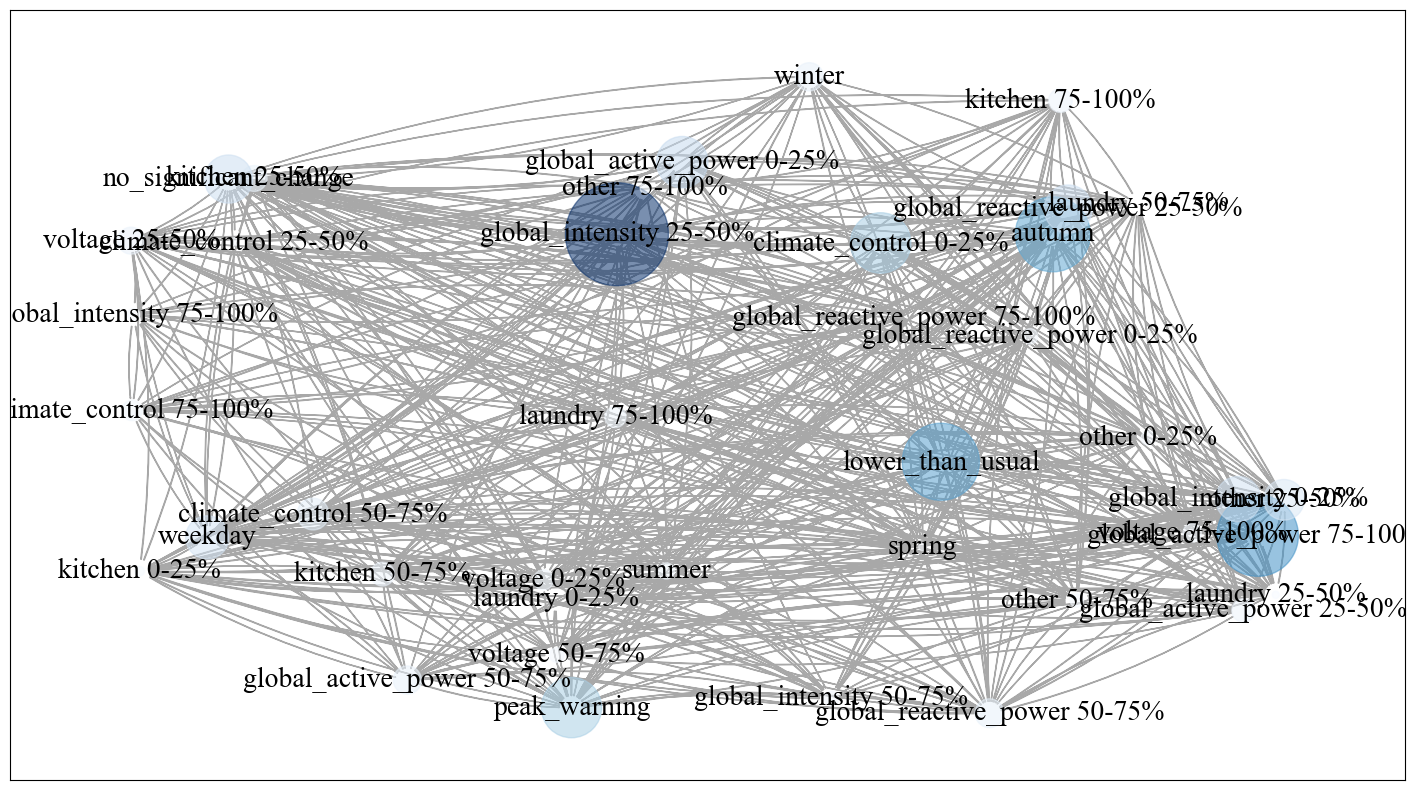

In [120]:
# Assume 'association_rules' is defined somewhere above this snippet
association_rules_pd = pd.DataFrame(association_rules)
association_rules_pd['length'] = association_rules_pd['items'].apply(lambda x: len(x))
association_rules_pd = association_rules_pd[association_rules_pd['length'] == 2]
association_rules_pd = association_rules_pd[association_rules_pd['length'] == 2]

# PageRank
G = nx.DiGraph()
G.add_edges_from(association_rules_pd['items'])
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 5500 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

# Layout
pos = nx.random_layout(G)

# Visualize
plt.figure(figsize=(18, 10))
nx.draw_networkx_nodes(G, pos, node_color=list(pr.values()), node_size=nsize, alpha=0.54, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, connectionstyle='arc3, rad=0.08', arrowstyle='fancy', arrowsize=1, edge_color='0.66')

# Adding labels with custom font
labels = nx.draw_networkx_labels(G, pos, font_size=20, font_family='Times New Roman')

plt.show()

In [72]:
# Structurize rules using graph structure (HC 중요도: PageRank)
association_rules_pd = pd.DataFrame(association_rules)
association_rules_pd['length'] = association_rules_pd['items'].apply(lambda x: len(x))
association_rules_pd = association_rules_pd[association_rules_pd['length']==2]

# PageRank
G = nx.DiGraph()
G.add_edges_from(association_rules_pd['items'])
pr = nx.pagerank(G)
nsize=np.array([v for v in pr.values()])
nsize = 5500*(nsize-min(nsize))/(max(nsize)-min(nsize))

# Layout
pos = nx.random_layout(G)
# Visualize
plt.figure(figsize=(18, 10))
# nx.draw_networkx(G, font_family='Times New Roman', font_size=20, pos=pos, node_color=list(pr.values()), node_size=nsize, alpha=1.0, edge_color='0.75')
nx.draw_networkx_nodes(G, pos, node_color=list(pr.values()), node_size=nsize, alpha=0.54, font_family='Times New Roman', font_size=20, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, connectionstyle='arc3, rad=0.08', arroswtyle='fancy', arrowsize=20, edge_color='0.66')
# nx.draw_networkx_labels(G, pos, font_size=24, font_family='Times New Roman')
plt.show()

TypeError: draw_networkx_nodes() got an unexpected keyword argument 'font_family'

<Figure size 1800x1000 with 0 Axes>

In [73]:
# Structurize rules using graph structure (HC 중요도: PageRank)
association_rules_pd = pd.DataFrame(association_rules)
association_rules_pd['length'] = association_rules_pd['items'].apply(lambda x: len(x))
association_rules_pd = association_rules_pd[association_rules_pd['length']==2]
# PageRank
G = nx.DiGraph()
G.add_edges_from(association_rules_pd['items'])
pr = nx.pagerank(G)
nsize=np.array([v for v in pr.values()])
nsize = 5500*(nsize-min(nsize))/(max(nsize)-min(nsize))
# Layout
pos = nx.shell_layout(G)
# Visualize
plt.figure(figsize=(22, 10))
# nx.draw_networkx(G, font_family='Times New Roman', font_size=20, pos=pos, node_color=list(pr.values()), node_size=nsize, alpha=1.0, edge_color='0.75')
nx.draw_networkx_nodes(G, pos, node_color=list(pr.values()), node_size=nsize, alpha=0.85, font_family='Times New Roman', font_size=20, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, connectionstyle='arc3, rad=0.45', arroswtyle='fancy', arrowsize=20, edge_color='0.8')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Times New Roman')
plt.show()

TypeError: draw_networkx_nodes() got an unexpected keyword argument 'font_family'

<Figure size 2200x1000 with 0 Axes>

In [74]:
# Structurize rules using graph structure (HC 중요도: PageRank)
association_rules_pd = pd.DataFrame(association_rules)
association_rules_pd['length'] = association_rules_pd['items'].apply(lambda x: len(x))
association_rules_pd = association_rules_pd[association_rules_pd['length']==2]
# PageRank
G = nx.DiGraph()
G.add_edges_from(association_rules_pd['items'])
pr = nx.pagerank(G)
nsize=np.array([v for v in pr.values()])
nsize = 5500*(nsize-min(nsize))/(max(nsize)-min(nsize))
# Layout
pos = nx.shell_layout(G)
# Visualize
plt.figure(figsize=(22, 10))
# nx.draw_networkx(G, font_family='Times New Roman', font_size=20, pos=pos, node_color=list(pr.values()), node_size=nsize, alpha=1.0, edge_color='0.75')
nx.draw_networkx_nodes(G, pos, node_color=list(pr.values()), node_size=nsize, alpha=0.9, font_family='Times New Roman', font_size=20, cmap=plt.cm.Blues)
nx.draw_networkx_edges(G, pos, connectionstyle='arc3, rad=0.45', arroswtyle='fancy', arrowsize=20, edge_color='0.5')
# nx.draw_networkx_labels(G, pos, font_size=20, font_family='Times New Roman')
plt.show()

TypeError: draw_networkx_nodes() got an unexpected keyword argument 'font_family'

<Figure size 2200x1000 with 0 Axes>